In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/transformer/DatasetB.csv
/kaggle/input/transformer/DatasetA.csv


Here, we have loaded the data and set Furan as the label.
At first, we have used 25 percent of the dataset A as the test set to come up with a good model, and then use this model to test in the dataset B.

In [2]:
ds_A = pd.read_csv("/kaggle/input/transformer/DatasetA.csv")
ds_B = pd.read_csv("/kaggle/input/transformer/DatasetB.csv")

# Splitting train and test
from sklearn.model_selection import train_test_split
train_set_A, test_set_A = train_test_split(ds_A, test_size = 0.25, random_state = 11)

# Setting the labels
y_train_A = train_set_A['Furan']
y_test_A = test_set_A['Furan']

# Dropping the Furan and Health Index columns
X_train_A = train_set_A.drop(["Furan", "HI"], axis = 1)
X_test_A = test_set_A.drop(["Furan", "HI"], axis = 1)

# For DatasetB
y_B = ds_B['Furan']
X_B = ds_B.drop(["Furan", "HI"], axis = 1)

# The code below is for the second case, where we train the data for the whole
# Dataset A and test it on Dataset B
y_A = ds_A['Furan']
X_A = ds_A.drop(["Furan", "HI"], axis = 1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The code below, drops the columns that we don't need, and only keeps the common features between dataset A and B.

In [3]:
X_train_A = X_train_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_test_A = X_test_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_A = X_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_B = X_B[X_train_A.columns]
X_train_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
109,12.2,53.50,6.9,127.4,48.0,3,0.043,83.0,20
566,30.2,0.00,0.0,2.6,1.1,3,0.005,84.0,39
410,45.6,18.20,0.0,1.6,1.7,5,0.005,87.0,30
316,19.7,38.50,0.0,2.7,41.6,7,0.005,50.0,32
678,11.0,7.60,0.0,0.3,1.6,3,0.005,61.0,42
...,...,...,...,...,...,...,...,...,...
269,13.7,5.10,0.0,0.4,1.1,1,0.005,94.0,36
337,32.9,3.77,0.0,0.6,2.4,6,0.005,79.0,32
91,22.8,3.30,0.0,4.9,3.0,11,0.140,88.0,16
80,61.2,27.30,0.0,25.6,20.8,9,0.099,70.0,17


The code below, discretizes the Furan data into 3 classes.

In [4]:
# define the bin edges for each class
bins = [-1, 0.1, 1, 100]

# define the labels for each class
labels = [0, 1, 2]

y_train_A = pd.DataFrame(y_train_A)
y_B = pd.DataFrame(y_B)
y_test_A = pd.DataFrame(y_test_A)
y_A = pd.DataFrame(y_A)

# discretize the data into 3 classes
y_train_A['Class'] = pd.cut(y_train_A['Furan'], bins=bins, labels=labels)
y_B['Class'] = pd.cut(y_B['Furan'], bins=bins, labels=labels)
y_test_A['Class'] = pd.cut(y_test_A['Furan'], bins=bins, labels=labels)
y_A['Class'] = pd.cut(y_A['Furan'], bins=bins, labels=labels)

y_train_A = np.array(y_train_A.drop("Furan", axis = 1)).ravel()
y_B = np.array(y_B.drop("Furan", axis = 1)).ravel()
y_test_A = np.array(y_test_A.drop("Furan", axis = 1)).ravel()
y_A = np.array(y_A.drop("Furan", axis = 1)).ravel()

The below code is a function to plot the confusion matrix

In [5]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# First case: Training using 75% of the data and testing on the remaining 25%

We have experimented a combination of different models in the ensemble.
Although the results were quite similar, we found that a combination of KNN, XGB and logistic regression works best.
In the code below we have created a voting classifier consist of these models.

In [6]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

#log_clf = LogisticRegression(max_iter=1000)
svm_clf = SVC(probability=True, gamma=0.001)
knn_clf = KNeighborsClassifier(n_neighbors=3)
xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nb_clf = GaussianNB()
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.003)
lr_clf = LogisticRegression(max_iter=10000)

voting_clf = VotingClassifier(
  estimators=[#('nn', mlp_clf),
              #('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),('nb', nb_clf)
              ('xgb', xgb_clf), ('lr', lr_clf)],
  voting='hard')
voting_clf.fit(X_train_A, np.array(y_train_A).ravel())

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lr', LogisticRegression(max_iter=10000))])

Here is a comparison of different models and the voting classifier.

In [7]:
from sklearn.metrics import accuracy_score
for clf in (mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, #nb_clf,
            lr_clf, voting_clf):
    clf.fit(X_train_A, y_train_A)
    y_pred_A = clf.predict(X_test_A)
    y_pred_B = clf.predict(X_B)
    print(clf.__class__.__name__ + " for dataset A:", accuracy_score(y_test_A, y_pred_A))
    print(clf.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier for dataset A: 0.8688524590163934
MLPClassifier for dataset B: 0.7828746177370031
SVC for dataset A: 0.8797814207650273
SVC for dataset B: 0.8103975535168195
KNeighborsClassifier for dataset A: 0.8360655737704918
KNeighborsClassifier for dataset B: 0.8042813455657493
XGBClassifier for dataset A: 0.8961748633879781
XGBClassifier for dataset B: 0.764525993883792
LogisticRegression for dataset A: 0.8633879781420765
LogisticRegression for dataset B: 0.7951070336391437
VotingClassifier for dataset A: 0.8961748633879781
VotingClassifier for dataset B: 0.8195718654434251


Confusion matrix, without normalization
[[130   0   2]
 [  4  11  11]
 [  1   1  23]]


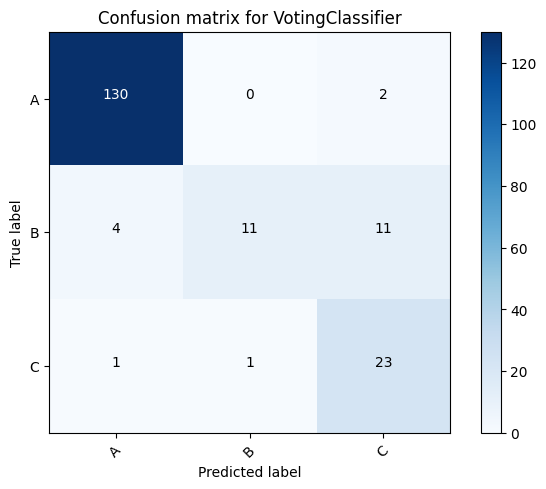

In [8]:
class_names = ['A', 'B', 'C']
voting_clf.fit(X_train_A, y_train_A)
y_pred_A = clf.predict(X_test_A)
cnf_matrix = confusion_matrix(y_test_A, y_pred_A)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + clf.__class__.__name__)
plt.show()

# Second case: Training using all of the data from Dataset A

So far we have used 75% of Dataset A to train the data and 25% to test it.
Here, we used all of the data from Dataset A to train, and then test it on Dataset B.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

lr_clf = LogisticRegression(max_iter=10000)
svm_clf = SVC(probability=True)
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nb_clf = GaussianNB()
#ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.003)

voting_clf = VotingClassifier(
  estimators=[#('nn', mlp_clf),
              #('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),('nb', nb_clf)
              ('xgb', xgb_clf), ('lr', lr_clf)],
  voting='hard')
voting_clf.fit(X_A, y_A)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lr', LogisticRegression(max_iter=10000))])

In [10]:
from sklearn.metrics import accuracy_score

for clf in (#mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, lr_clf, #nb_clf,
            voting_clf):
    clf.fit(X_A, y_A)
    y_pred_B = clf.predict(X_B)
    print(clf.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

KNeighborsClassifier for dataset B: 0.8379204892966361
XGBClassifier for dataset B: 0.7706422018348624
LogisticRegression for dataset B: 0.8134556574923547
VotingClassifier for dataset B: 0.8256880733944955


The code below is a function to visualize the confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix:

Confusion matrix, without normalization
[[245   8   4]
 [ 11  11  18]
 [  8   4  18]]


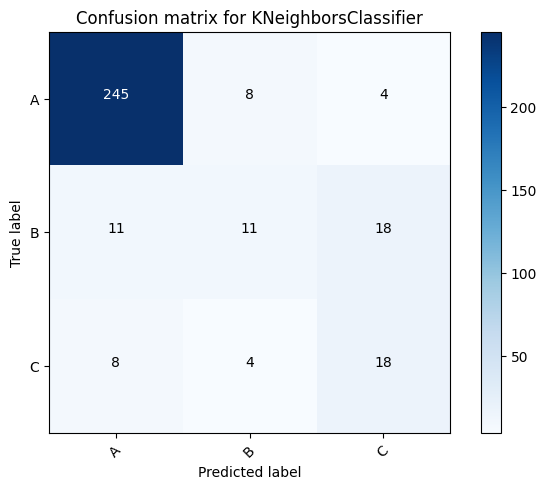

Confusion matrix, without normalization
[[222  20  15]
 [  6   3  31]
 [  3   0  27]]


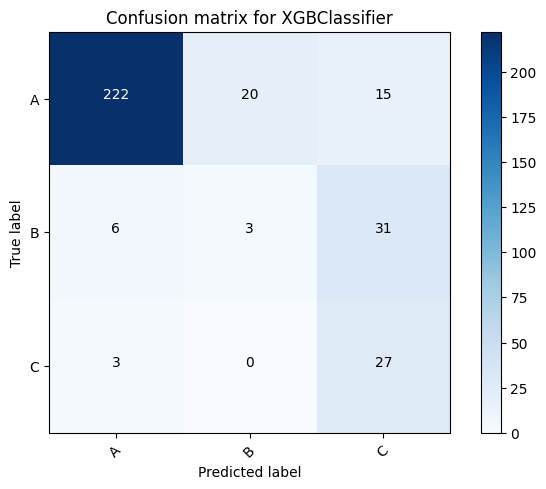

Confusion matrix, without normalization
[[235  17   5]
 [ 10   7  23]
 [  5   1  24]]


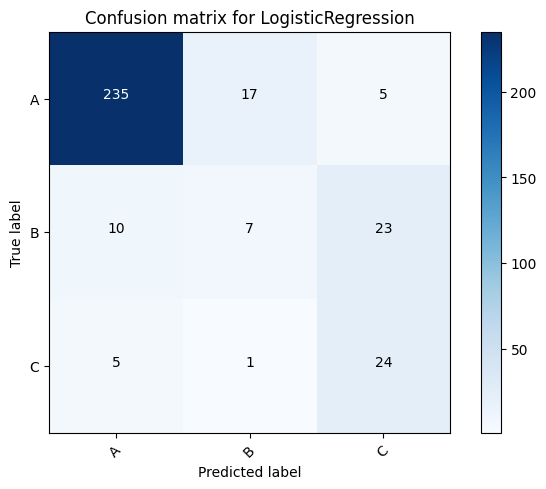

Confusion matrix, without normalization
[[242  10   5]
 [ 10   3  27]
 [  5   0  25]]


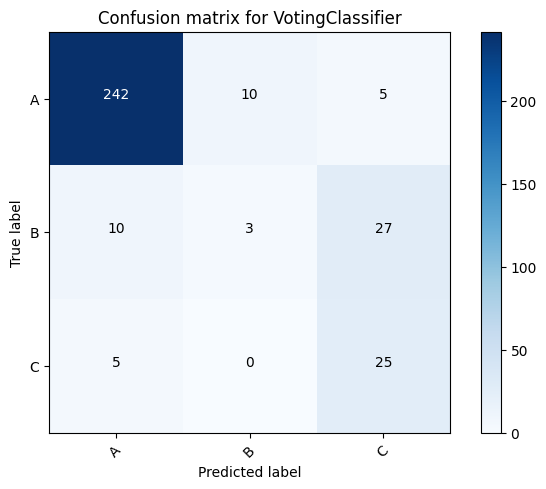

In [12]:
class_names = ['A', 'B', 'C']

for clf in (#mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, lr_clf, #nb_clf,
            voting_clf):
    clf.fit(X_A, y_A)
    y_pred_B = clf.predict(X_B)
    cnf_matrix = confusion_matrix(y_B, y_pred_B)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix for ' + clf.__class__.__name__)
    plt.show()

Confusion matrix, without normalization
[[242  10   5]
 [ 10   3  27]
 [  5   0  25]]


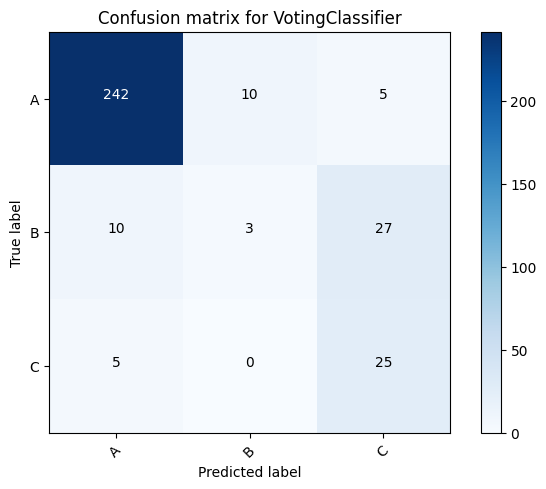

In [13]:
class_names = ['A', 'B', 'C']
voting_clf.fit(X_A, y_A)
y_pred_B = voting_clf.predict(X_B)
cnf_matrix = confusion_matrix(y_B, y_pred_B)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for ' + clf.__class__.__name__)
plt.show()